# OPEN CV Line Detection

https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

from config.path import get_training_data_path

import cv2
import numpy as np
import matplotlib.pyplot as plt

Average Angle:  17.59867214401756


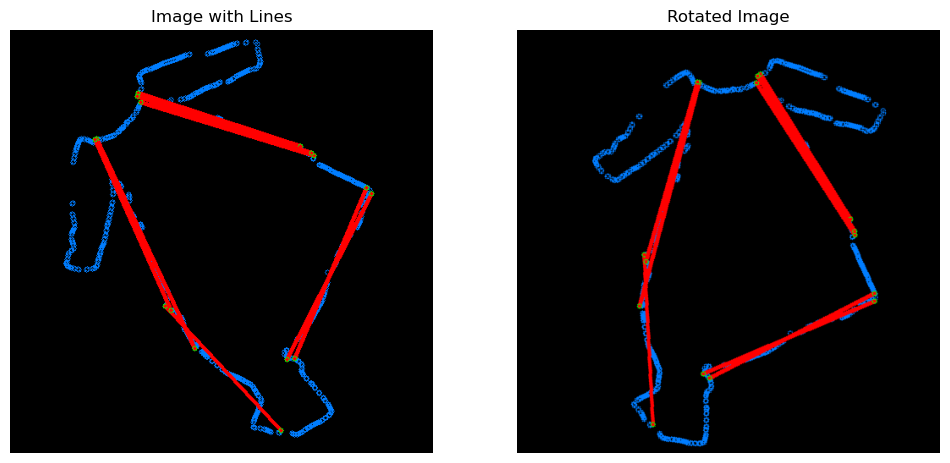

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 
def correct_rotation_and_display_with_lines(image_path=""):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying
    #image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # Convert to grayscale and equalize histogram
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)

    # # Define the range of rotation angles
    # min_angle = -45
    # max_angle = 45

    # # Generate a random angle within the specified range
    # angle = random.uniform(min_angle, max_angle)

    # width, height = image.shape[1], image.shape[0]
    # rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
    # image = cv2.warpAffine(image, rotation_matrix, (width, height))

    # Detect edges
    edges = cv2.Canny(gray, 10, 100, apertureSize=3)
    
    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=10, minLineLength=100, maxLineGap=40)

    if lines is not None:
        # Prepare to calculate the average angle
        sin_sum = 0
        cos_sum = 0

        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            #print(length)
            if length > 200:
                cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Draw each detected line in red
                cv2.circle(image, (x1, y1), 3, (0, 255, 0)) 
                cv2.circle(image, (x2, y2), 3, (0, 255, 0)) 
                angle = np.arctan2(y2 - y1, x2 - x1)
                sin_sum += np.sin(angle)
                cos_sum += np.cos(angle)

        # Calculate average angle using vector sums
        average_angle = np.arctan2(sin_sum, cos_sum)
        average_angle_degrees = np.degrees(average_angle)

        print("Average Angle: ", average_angle_degrees)

        # Rotate image to align
        width, height = image.shape[1], image.shape[0]
        rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), -40, 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    else:
        rotated_image = image  # No rotation if no lines are detected

    # Display the original and rotated images using matplotlib
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Image with Lines')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(rotated_image)
    plt.title('Rotated Image')
    plt.axis('off')

    plt.show()


# relative_path = get_training_data_path('classifier', 'dress')

# full_path = os.path.join(relative_path, 'dress33.jpg')
correct_rotation_and_display_with_lines('./test.png')

In [18]:
import numpy as np
import cv2

# Load your image and convert to grayscale
image = cv2.imread('test.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming you have a single contour of the object
contour = contours[0]

# 1. Compute the centroid of the contour
moments = cv2.moments(contour)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])
centroid = (cx, cy)

# 2. Fit an ellipse to the contour
ellipse = cv2.fitEllipse(contour)
ellipse_center = (int(ellipse[0][0]), int(ellipse[0][1]))
ellipse_angle = ellipse[2]

# 3. Principal Component Analysis (PCA) to find the symmetry line
data_pts = contour.reshape(-1, 2).astype(np.float32)
mean, eigenvectors = cv2.PCACompute(data_pts, mean=np.array([]))

# The first eigenvector corresponds to the principal axis
p1 = (int(mean[0, 0] - 200 * eigenvectors[0, 0]), int(mean[0, 1] - 200 * eigenvectors[0, 1]))
p2 = (int(mean[0, 0] + 200 * eigenvectors[0, 0]), int(mean[0, 1] + 200 * eigenvectors[0, 1]))

# Draw the symmetry line
cv2.line(image, p1, p2, (0, 255, 0), 2)
cv2.circle(image, centroid, 5, (255, 0, 0), -1)

# Show the result
cv2.imshow('Symmetry Line', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


IndexError: tuple index out of range